# Import Libraries & Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

import seaborn as sns
sns.set_theme(style="darkgrid")

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.DataFrame(pd.read_csv('perrin-freres-monthly-champagne.csv', header=0, index_col=0, parse_dates=True))
series = df.columns[0]
df.head()

,Sales in Millions
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


# Exploratory Data Analysis

In [3]:
print(df.shape)
print(df.isnull().sum())

(105, 1)
Sales in Millions    0
dtype: int64


In [4]:
import statsmodels.tsa.api as smt
import scipy.stats as scs

def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

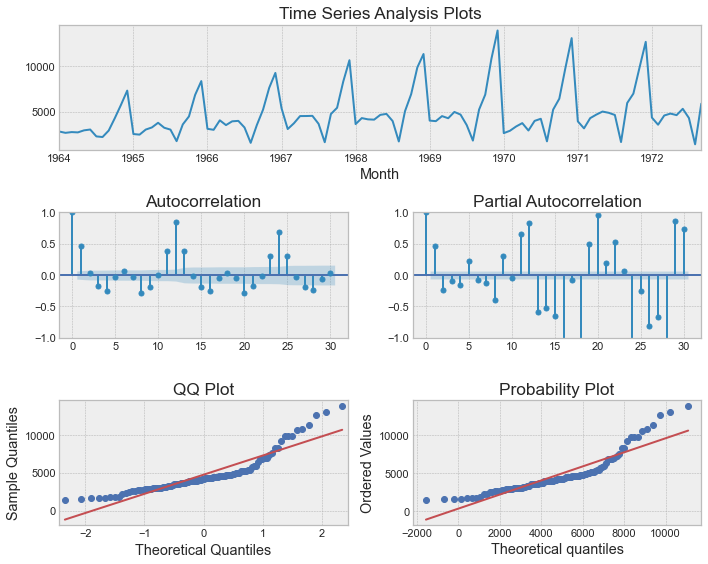

In [5]:
tsplot(df[series], lags=30)

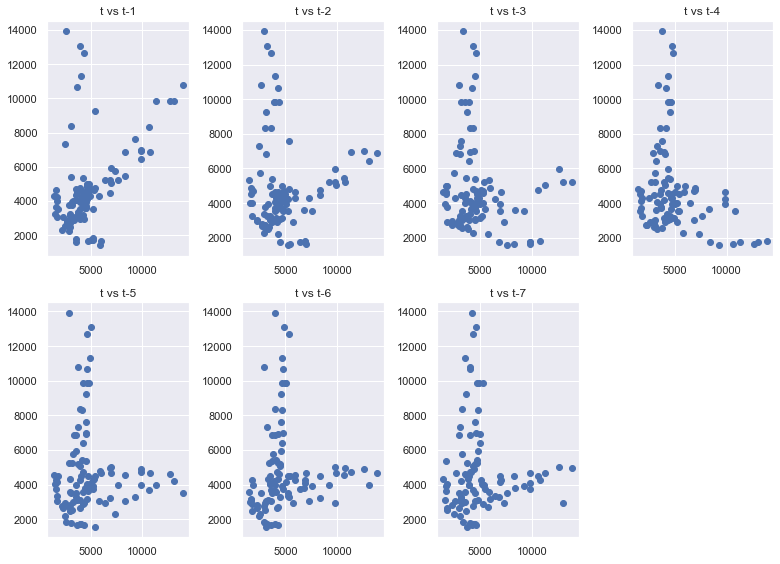

In [6]:
plt.figure(figsize=(11,8))

values = pd.DataFrame(df.values)
lags = 7
columns = [values]
for i in range(1,(lags + 1)):
    columns.append(values.shift(i))
dataframe = pd.concat(columns, axis=1)
columns = ['t']
for i in range(1,(lags + 1)):
    columns.append('t-' + str(i))
dataframe.columns = columns
plt.figure(1)
for i in range(1,(lags + 1)):
    ax = plt.subplot(240 + i)
    ax.set_title('t vs t-' + str(i))
    plt.scatter(x=dataframe['t'].values, y=dataframe['t-'+str(i)].values)
plt.tight_layout()
plt.show()

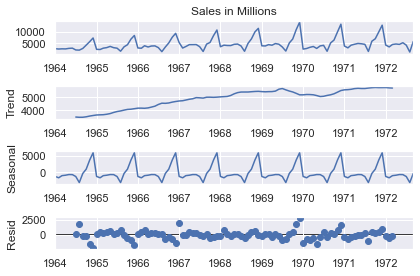

In [7]:
decomposed = sm.tsa.seasonal_decompose(df[series],period=12)
figure = decomposed.plot()
plt.show()

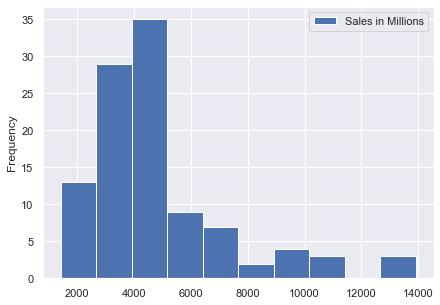

In [8]:
df.plot(kind='hist', figsize=(7,5));

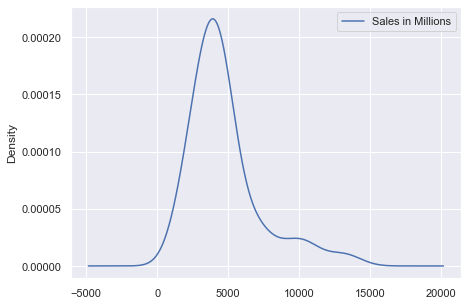

In [9]:
df.plot(kind='kde', figsize=(7,5));

# Stationarity

In [10]:
from statsmodels.tsa.stattools import adfuller

def adf(x):
    res = adfuller(x)
    print("Test-Statistic:", res[0])
    print("P-Value:", res[1])
    if res[1] < 0.05:
        print("Stationary")
    else:
        print("Non-Stationary")

adf(df[series])

Test-Statistic: -1.8335930563276186
P-Value: 0.36391577166024713
Non-Stationary


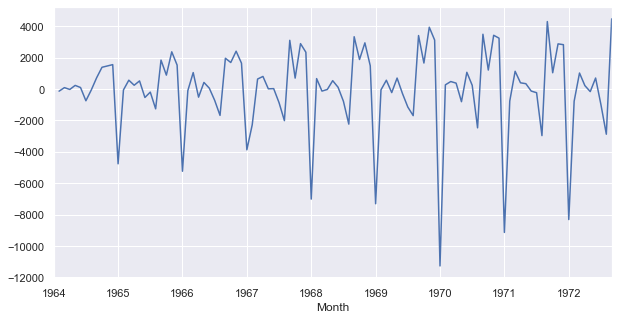

In [11]:
df['diff1'] = df[series].diff()
df['diff1'].plot(figsize=(10,5));

In [12]:
df.dropna(axis=0, how='any', inplace=True)
adf(df['diff1'])

Test-Statistic: -7.18989644805098
P-Value: 2.519620447387365e-10
Stationary


# Error Metrics

In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

def rmse(actual, pred):
    return np.sqrt(np.mean((actual - pred)**2))

# Naive/Persistence Forecast

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
try:
    df.drop(columns='diff1', inplace=True)
except:
    pass
df.head()

try:
    df.drop(columns='EWMA', inplace=True)
except:
    pass
df.head()

,Sales in Millions
Month,
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0
1964-06-01,3036.0


MAPE: 44.23%
RMSE: 2651
MAE: 1721
R2: -0.08


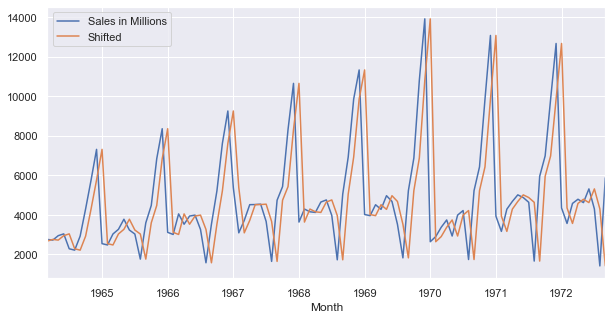

In [15]:
df_copy = df
df_copy['Shifted'] = df_copy[series].shift(1)
df_copy.dropna(axis=0, how='any', inplace=True)

mape_result = mape(df_copy[series], df_copy['Shifted'])
rmse_result = rmse(df_copy[series], df_copy['Shifted'])
mae_result = mean_absolute_error(df_copy[series], df_copy['Shifted'])
r2_result = r2_score(df_copy[series], df_copy['Shifted'])

print('MAPE: %.2f%%' % mape_result)
print('RMSE: %.0f' % rmse_result)
print('MAE: %.0f' % mae_result)
print('R2: %.2f' % r2_result)

df_copy[[series, 'Shifted']].plot();

# Double Exponential Smoothing

In [16]:
try:
    df.drop(columns='Shifted', inplace=True)
except:
    pass
df.head()

,Sales in Millions
Month,
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0
1964-06-01,3036.0
1964-07-01,2282.0


In [ ]:
from statsmodels.tsa.holtwinters import Holt
holt = Holt(df[series])
result = holt.fit(optimized=True)
result.params

In [ ]:
df['Holt'] = result.predict(start=df.index[0], end=df.index[-1])

mape_result = mape(df['Holt'], df[series])
rmse_result = rmse(df['Holt'], df[series])
mae_result = mean_absolute_error(df['Holt'], df[series])
r2_result = r2_score(df['Holt'], df[series])

print('MAPE: %.2f%%' % mape_result)
print('RMSE: %.0f' % rmse_result)
print('MAE: %.0f' % mae_result)
print('MAE: %.2f' % r2_result)

df.plot(figsize=(10,5));

### Walkforward Validation

In [21]:
from statsmodels.tsa.holtwinters import Holt

In [22]:
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

n_test = 24
X = df[series].values
train, test = train_test_split(X, n_test)

In [23]:
def forecast(history, param_model):
    model = param_model(history)
    model_fit = model.fit(optimized=True)
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

In [24]:
def walkforward_val(history, param_model):
    predictions = list()
    history = [x for x in train]
    
    for i in range(len(test)):
        yhat = forecast(history, param_model)
        predictions.append(yhat)
        history.append(test[i])
    
    mape_result = mape(test, predictions)
    rmse_result = rmse(test, predictions)
    mae_result = mean_absolute_error(test, predictions)
    r2_result = r2_score(test, predictions)
    
    print('MAPE: %.2f%%' % mape_result)
    print('RMSE: %.0f' % rmse_result)
    print('MAE: %.0f' % mae_result)
    print('R2: %.2f' % r2_result)

    plt.plot(test)
    plt.plot(predictions, 'r')
    plt.show();
    
    return predictions

MAPE: 66.26%
RMSE: 3631
MAE: 2759
R2: -0.57


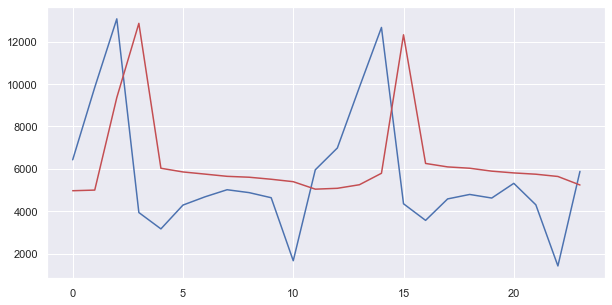

In [25]:
predictions = walkforward_val(train, Holt)

# Triple Exponential Smoothing

In [28]:
try:
    df.drop(columns='Holt', inplace=True)
except:
    pass
df.head()

,Sales in Millions
Month,
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0
1964-06-01,3036.0
1964-07-01,2282.0


In [30]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [31]:
data = df[series].values
train, test = train_test_split(data,n_test)

In [32]:
def exp_smoothing_forecast(history,t,d,s,p):
    model = ExponentialSmoothing(history, 
                                 trend=t, 
                                 damped=d, 
                                 seasonal=s, 
                                 seasonal_periods=p)
    model_fit = model.fit(optimized=True)
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

In [33]:
def walkforward_validation(history,t,d,s,p):
    predictions = list()
    history = [x for x in train]
    for i in range(len(test)):
        yhat = exp_smoothing_forecast(history,t,d,s,p)
        predictions.append(yhat)
        history.append(test[i])
    error = rmse(test, predictions)
    return error

### Parameter Searching

In [34]:
print('additive, no damping')
history = [x for x in train]
for p in (2,3,4,5,6,7,8,9,10,12,24):
    error = walkforward_validation(history, 'add', False, 'add', p)
    msg = "p=%.0f:, RMSE=%.0f" % (p, error)
    print(msg)

additive, no damping
p=2:, RMSE=3385
p=3:, RMSE=3003
p=4:, RMSE=3220
p=5:, RMSE=3701
p=6:, RMSE=2343
p=7:, RMSE=3515
p=8:, RMSE=3270
p=9:, RMSE=3527
p=10:, RMSE=3538
p=12:, RMSE=558
p=24:, RMSE=1161


In [35]:
print('multiplicative, no damping')
for p in (2,3,4,5,6,7,8,9,10,12,24):
    error = walkforward_validation(history, 'mul', False, 'mul', p)
    msg = "p=%.0f:, RMSE=%.0f" % (p, error)
    print(msg)

multiplicative, no damping
p=2:, RMSE=3380
p=3:, RMSE=2975
p=4:, RMSE=3256
p=5:, RMSE=3524
p=6:, RMSE=1666
p=7:, RMSE=3705
p=8:, RMSE=2762
p=9:, RMSE=2546
p=10:, RMSE=3936
p=12:, RMSE=610
p=24:, RMSE=682


In [36]:
print('additive, with damping')
for p in (2,3,4,5,6,7,8,9,10,12,24):
    error = walkforward_validation(history, 'add', True, 'add', p)
    msg = "p=%.0f:, RMSE=%.0f" % (p, error)
    print(msg)

additive, with damping
p=2:, RMSE=3396
p=3:, RMSE=2989
p=4:, RMSE=3342
p=5:, RMSE=3912
p=6:, RMSE=2332
p=7:, RMSE=3611
p=8:, RMSE=3643
p=9:, RMSE=3172
p=10:, RMSE=3514
p=12:, RMSE=556
p=24:, RMSE=934


### Walkforward Validation

MAPE: 10.32%
RMSE: 558
MAE: 422
R2: 0.96


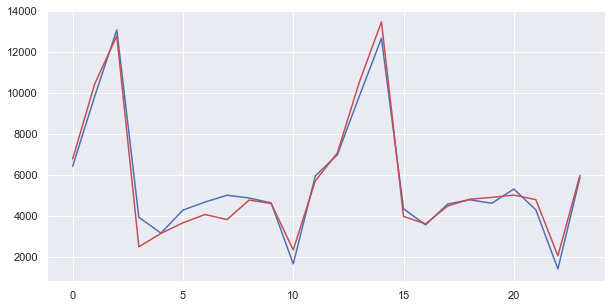

In [37]:
t = 'add'
d = False
s = 'add'
p = 12

predictions = list()
history = [x for x in train]
for i in range(len(test)):
    yhat = exp_smoothing_forecast(history,t,d,s,p)
    predictions.append(yhat)
    history.append(test[i])
    
mape_result = mape(test, predictions)
rmse_result = rmse(test, predictions)
mae_result = mean_absolute_error(test, predictions)
r2_result = r2_score(test, predictions)

print('MAPE: %.2f%%' % mape_result)
print('RMSE: %.0f' % rmse_result)
print('MAE: %.0f' % mae_result)
print('R2: %.2f' % r2_result)

plt.plot(test);
plt.plot(predictions, color='r');

#### Analysis of Residuals

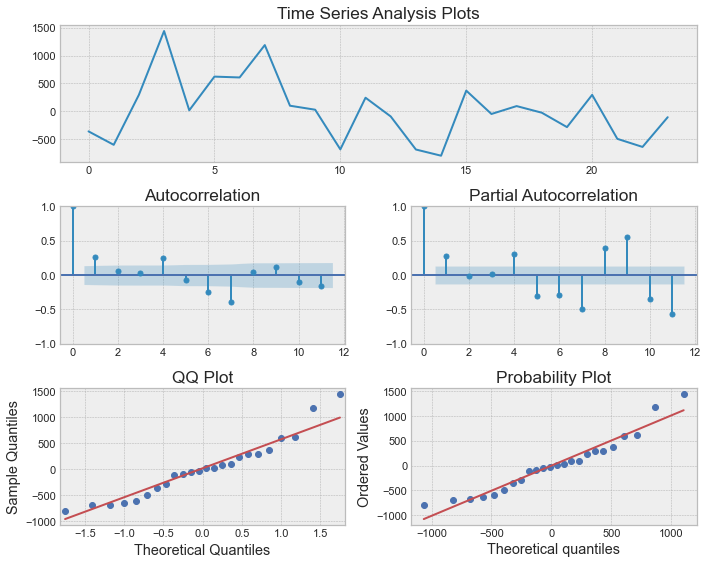

In [38]:
residuals = test - predictions
tsplot(residuals, lags=11)

In [39]:
adf(residuals)

Test-Statistic: -1.120369344547229
P-Value: 0.7068808705215344
Non-Stationary


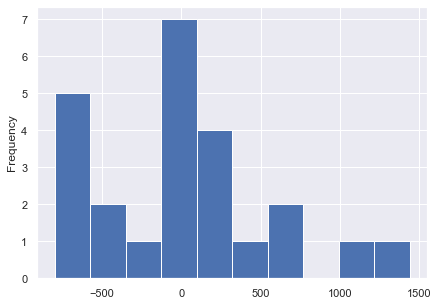

In [40]:
res = pd.Series(residuals)
res.plot(kind='hist', figsize=(7,5));

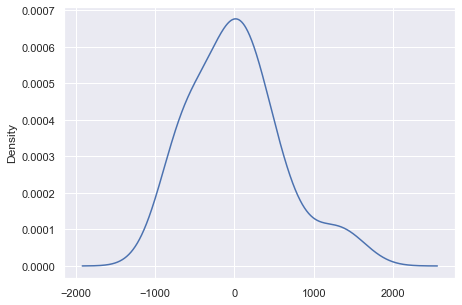

In [41]:
res.plot(kind='kde', figsize=(7,5));

### Multi-Step Prediction

MAPE: 12.76%
RMSE: 709
MAE: 503
R2: 0.92


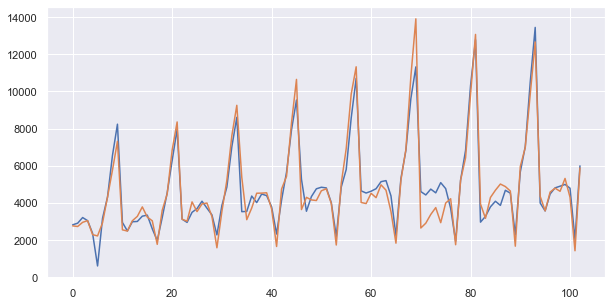

In [42]:
model = ExponentialSmoothing(history, 
                             trend=t, 
                             damped=d, 
                             seasonal=s, 
                             seasonal_periods=p)
model_fit = model.fit(optimized=True)
yhat = model_fit.predict(0, len(history) - 1)

mape_result = mape(history, yhat)
rmse_result = rmse(history, yhat)
mae_result = mean_absolute_error(history, yhat)
r2_result = r2_score(history, yhat)

print('MAPE: %.2f%%' % mape_result)
print('RMSE: %.0f' % rmse_result)
print('MAE: %.0f' % mae_result)
print('R2: %.2f' % r2_result)

plt.plot(yhat);
plt.plot(history);

#### Analysis of Residuals

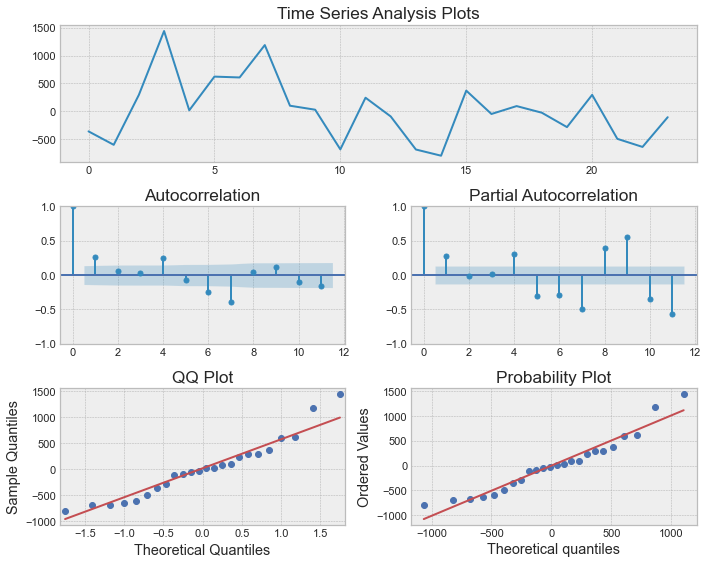

In [43]:
residuals = test - predictions
tsplot(residuals, lags=11)

In [44]:
adf(residuals)

Test-Statistic: -1.120369344547229
P-Value: 0.7068808705215344
Non-Stationary


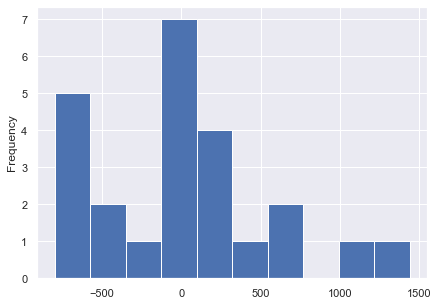

In [45]:
res = pd.Series(residuals)
res.plot(kind='hist', figsize=(7,5));

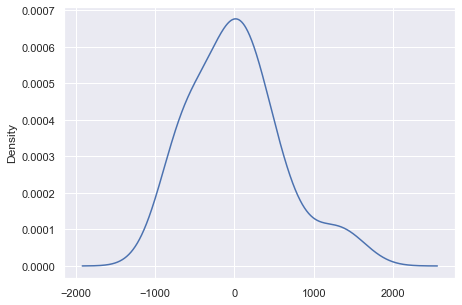

In [46]:
res.plot(kind='kde', figsize=(7,5));

# ARIMA

In [47]:
try:
    df.drop(columns='Holt', inplace=True)
except:
    pass
df.head()

,Sales in Millions
Month,
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0
1964-06-01,3036.0
1964-07-01,2282.0


### Parameter Searching

In [48]:
import pmdarima as pm

In [49]:
model = pm.auto_arima(train[:],
                      trace=True,
                      suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1434.883, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1456.311, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1438.709, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1434.399, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1575.758, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1437.146, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1436.441, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1438.410, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1507.036, Time=0.04 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.377 seconds


### Walkforward Validation

In [50]:
from statsmodels.tsa.arima.model import ARIMA

In [51]:
p = 0
d = 0
q = 1
order = (p,d,q)

In [52]:
def evaluate_arima_model(X, n_test):
    
    train_size = int(len(X) - n_test)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(order))
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        
    mape_result = mape(test, predictions)
    rmse_result = rmse(test, predictions)
    mae_result = mean_absolute_error(test, predictions)
    r2_result = r2_score(test, predictions)

    print('MAPE: %.2f%%' % mape_result)
    print('RMSE: %.0f' % rmse_result)
    print('MAE: %.0f' % mae_result)
    print('MAPE: %.2f' % r2_result)
    
    plt.plot(test)
    plt.plot(predictions, 'r')
    plt.show();
    
    return predictions

MAPE: 44.17%
RMSE: 2716
MAE: 2054
MAPE: 0.12


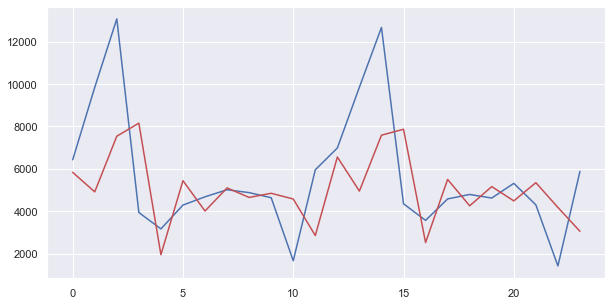

In [53]:
predictions = evaluate_arima_model(df[series].values, n_test)

### Multi-Step Prediction

In [54]:
train = df.iloc[:-n_test]
test = df.iloc[-n_test:]
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

str_order = str(order)
arima = ARIMA(train[series], order=order)
arima_result = arima.fit()
df.loc[train_idx, 'AR %s' % str_order] = arima_result.predict(start=train.index[0], end=train.index[-1])

prediction = arima_result.get_forecast(n_test)
forecast = pd.Series(prediction.predicted_mean)
df.loc[test_idx, 'AR %s' % str_order] = forecast

MAPE: 36.19%
RMSE: 3081
MAE: 1870
R2: -0.13


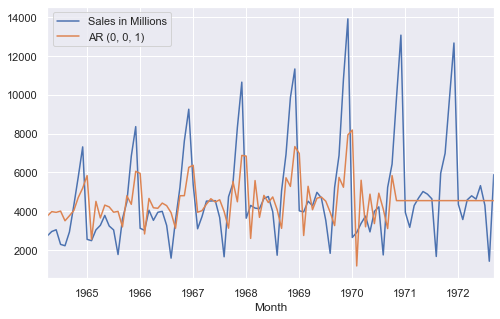

In [55]:
train, test = train_test_split(df, n_test)

mape_result = mape(test[series], test['AR %s' % str_order])
rmse_result = rmse(test[series], test['AR %s' % str_order])
mae_result = mean_absolute_error(test[series], test['AR %s' % str_order])
r2_result = r2_score(test[series], test['AR %s' % str_order])

print('MAPE: %.2f%%' % mape_result)
print('RMSE: %.0f' % rmse_result)
print('MAE: %.0f' % mae_result)
print('R2: %.2f' % r2_result)

df_copy = df.iloc[1:]
df_copy[[series, 'AR %s' % str_order]].plot(figsize=(8, 5));

# SARIMA

In [56]:
try:
    train.drop(columns='AR %s' % str_order, inplace=True)
except:
    pass

try:
    test.drop(columns='AR %s' % str_order, inplace=True)
except:
    pass

try:
    df.drop(columns='AR %s' % str_order, inplace=True)
except:
    pass

In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Parameter Searching

In [58]:
model = pm.auto_arima(train[:],
                      trace=True,
                      suppress_warnings=True,
                      seasonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1079.602, Time=0.72 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1104.628, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1092.167, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1074.708, Time=0.20 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1072.726, Time=0.05 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1074.695, Time=0.19 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1074.380, Time=0.08 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=1074.347, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1092.467, Time=0.02 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1074.461, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,1,0)[12]          
Total fit time: 2.278 seconds


In [59]:
p = 0
d = 0
q = 0
P = 0
D = 1
Q = 0
m = 12
order = (p,d,q)
s_order = (P,D,Q,m)

### Walkforward Validation

In [60]:
def evaluate_sarima_model(X, n_test):
    
    train_size = int(len(X) - n_test)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    predictions = list()
    for t in range(len(test)):
        model = SARIMAX(history, order=(order), seasonal_order=(s_order))
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        
    mape_result = mape(test, predictions)
    rmse_result = rmse(test, predictions)
    mae_result = mean_absolute_error(test, predictions)
    r2_result = r2_score(test, predictions)

    print('MAPE: %.2f%%' % mape_result)
    print('RMSE: %.0f' % rmse_result)
    print('MAE: %.0f' % mae_result)
    print('R2: %.2f' % r2_result)
    
    plt.plot(test)
    plt.plot(predictions, 'r')
    plt.show();
    
    return predictions

MAPE: 11.48%
RMSE: 723
MAE: 564
R2: 0.94


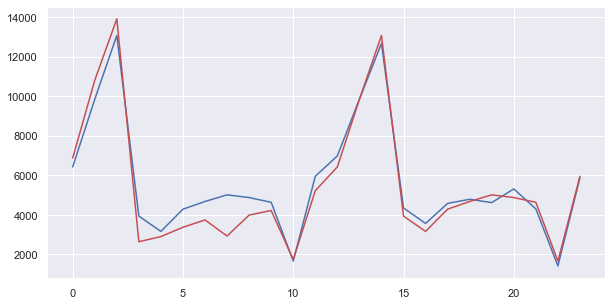

In [61]:
predictions = evaluate_sarima_model(df[series].values, n_test)

#### Analysis of Residuals

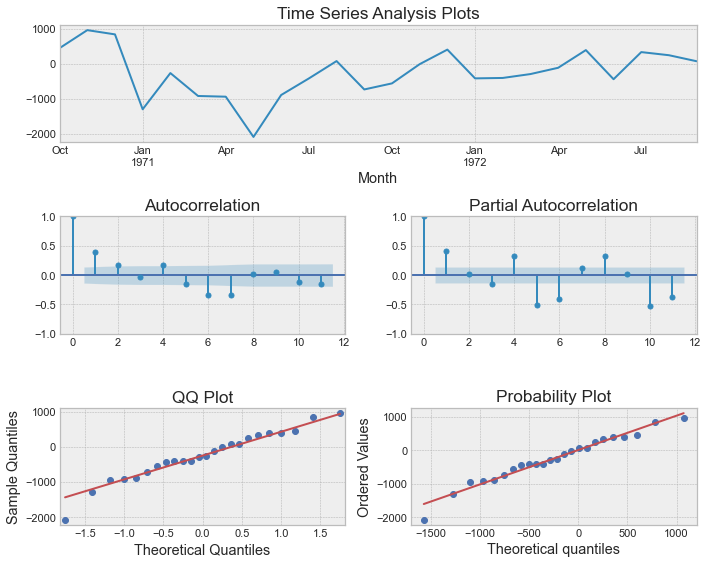

In [62]:
residuals = predictions - test[series]
tsplot(residuals, lags=11)

In [63]:
adf(residuals)

Test-Statistic: -1.499079669021522
P-Value: 0.5339665642590242
Non-Stationary


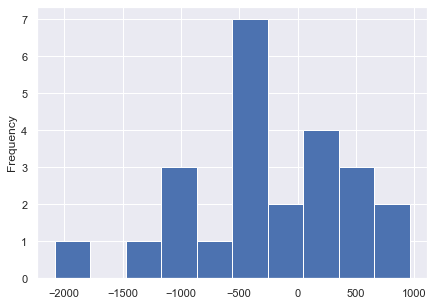

In [64]:
res = pd.Series(residuals)
res.plot(kind='hist', figsize=(7,5));

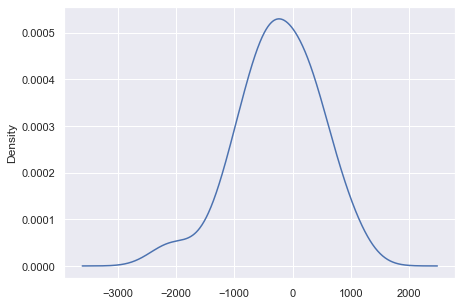

In [65]:
res.plot(kind='kde', figsize=(7,5));

### Multi-Step Prediction

MAPE: 14.49%
RMSE: 853
MAE: 648
R2: 0.88


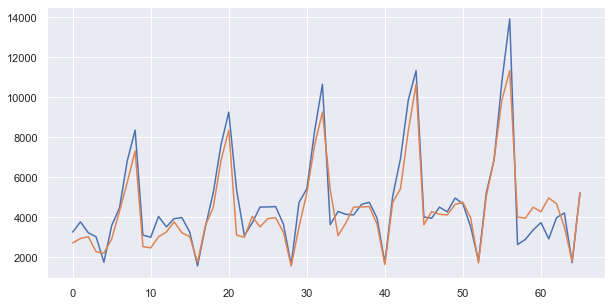

In [66]:
model = SARIMAX(train[:], order=(0,0,0), seasonal_order=(0,1,0,12))
result = model.fit()
train_pred = result.predict(0, len(train) - 1)

train_copy = np.array([x for x in train[series][13:]])
train_pred_copy = np.array([x for x in train_pred[13:]])

mape_result = mape(train_copy, train_pred_copy)
rmse_result = rmse(train_copy, train_pred_copy)
mae_result = mean_absolute_error(train_copy, train_pred_copy)
r2_result = r2_score(train_copy, train_pred_copy)

print('MAPE: %.2f%%' % mape_result)
print('RMSE: %.0f' % rmse_result)
print('MAE: %.0f' % mae_result)
print('R2: %.2f' % r2_result)

plt.plot(train_copy)
plt.plot(train_pred_copy);

In [67]:
test_pred = result.predict(len(train), len(train) + len(test) - 1)

MAPE: 17.35%
RMSE: 1014
MAE: 870
R2: 0.88


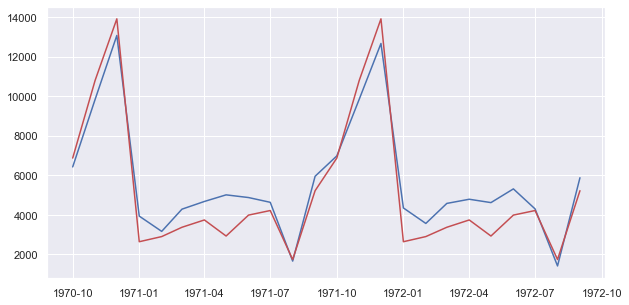

In [68]:
test_copy = np.array([x for x in test[series]])
test_pred_copy = np.array([x for x in test_pred])

mape_result = mape(test_copy, test_pred_copy)
rmse_result = rmse(test_copy, test_pred_copy)
mae_result = mean_absolute_error(test_copy, test_pred_copy)
r2_result = r2_score(test_copy, test_pred_copy)

print('MAPE: %.2f%%' % mape_result)
print('RMSE: %.0f' % rmse_result)
print('MAE: %.0f' % mae_result)
print('R2: %.2f' % r2_result)

plt.plot(test)
plt.plot(test_pred, color='r');

#### Analysis of Residuals

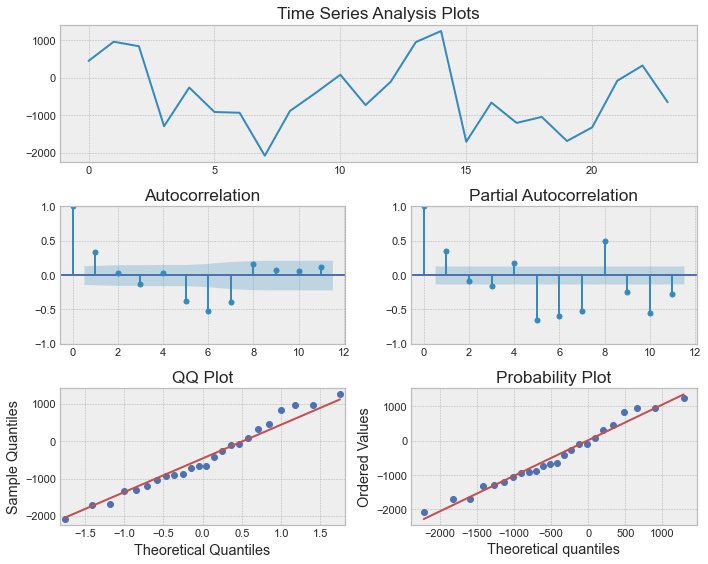

In [69]:
residuals = test_pred_copy - test_copy
tsplot(residuals, lags=11)

In [70]:
adf(residuals)

Test-Statistic: -2.425556783721065
P-Value: 0.1346527242887784
Non-Stationary


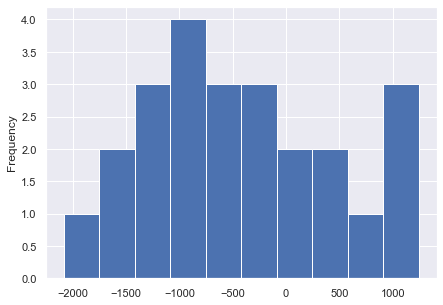

In [71]:
res = pd.Series(residuals)
res.plot(kind='hist', figsize=(7,5));

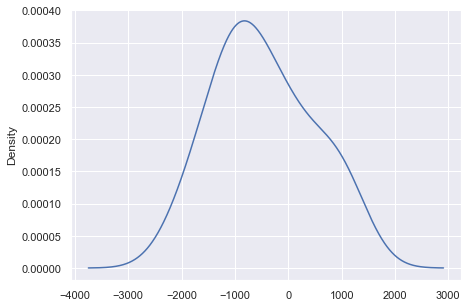

In [72]:
res.plot(kind='kde', figsize=(7,5));